In [1004]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import os.path

%matplotlib inline

In [1005]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [1006]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1007]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [1008]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        
        # the tensor [latent_size x 1] representing the average activations of each hidden unit j over batch(!)
        self.data_rho = h.mean(0)
        
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        
        Thus D_KL(P||Q) is proportional to  (-p*log(q) - (1-p)*log(1-q))
        """
        dkl = -rho * torch.log(self.data_rho) - (1-rho) * torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [1009]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [1010]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [1011]:
model_filename = './model_64.h5'

In [1012]:
if not os.path.isfile(model_filename):
    models = {'16': Net(16), '32': Net(32), '64': Net(64)}
    rho = 0.05
    train_log = {k: [] for k in models}
    test_log = {k: [] for k in models}

    [model.to(device) for model in models.values()];

In [1013]:
# Train if no model has been pretrained
if not os.path.isfile(model_filename):
    for epoch in range(1, 21):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, test_log)

In [1014]:
if not os.path.isfile(model_filename):
    # save the model
    torch.save(models['64'], model_filename)

In [1015]:
model64 = torch.load(model_filename)

In [1016]:
data, _ = next(iter(test_loader))
output = model64(data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = model64.decode(torch.eye(64).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = model64.E(data.view(-1, 28*28).to(device))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model64.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([ 5,  4,  2,  8,  7,  4,  4,  4,  5,  3,  8,  5,  4,  5,
         4,  6,  5,  5,  2,  2,  4,  8,  5,  5,  2,  7,  6,  5,
         5,  6,  3,  4,  5,  4,  5,  7,  4,  4,  3,  3,  5,  2,
         5,  0,  7,  3,  7,  3,  8,  9])


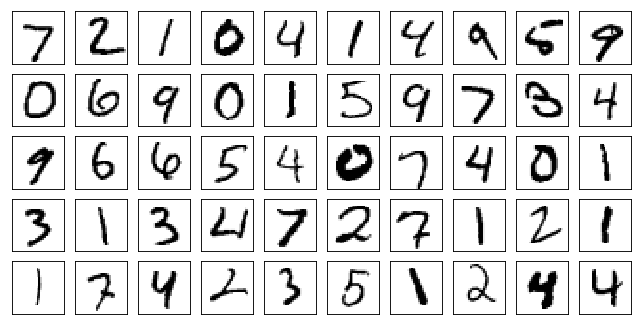

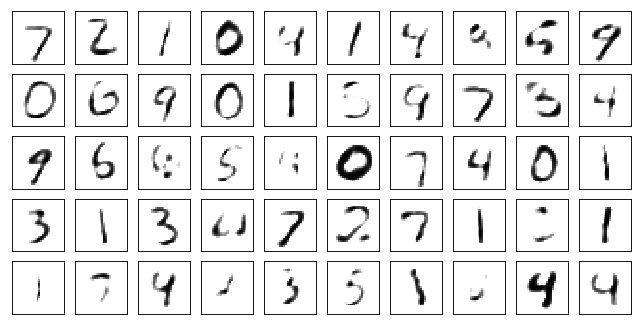

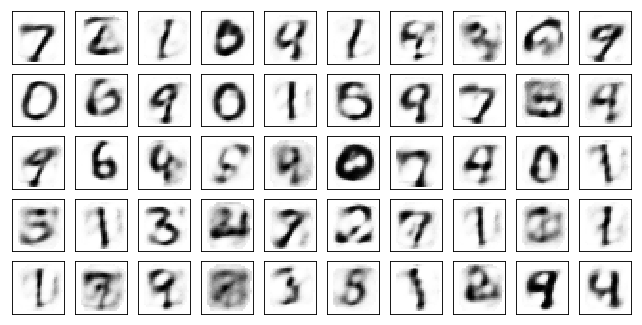

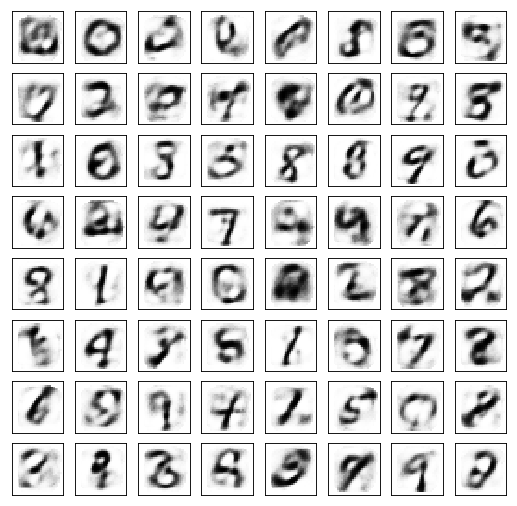

In [1017]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

### 1. initialize inputs with all zeros

In [1115]:
inputs = torch.zeros([64, 1, 28, 28])
print("Sum of elements: {}".format(inputs.sum().item()))
print("Tensor shape: {}".format(inputs.shape))

Sum of elements: 0.0
Tensor shape: torch.Size([64, 1, 28, 28])


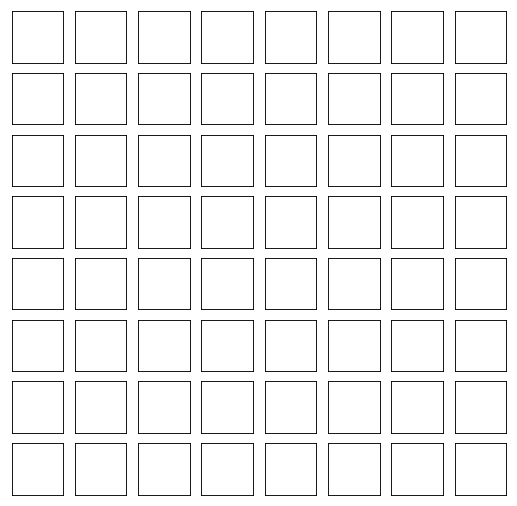

In [1116]:
inputs_to_plot = ((inputs.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(inputs_to_plot, shape=(8, 8))

In [1117]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [1118]:
def step(i, print_every=100):
    inputs_optim.zero_grad()
    
    # calculate loss b/w 
    loss = F.mse_loss(model64.E(w.view(-1, 28*28)), torch.eye(64))    
    loss_ = loss.item()
    loss.backward()
    
    # print
    if i % print_every == 0:
        print("{}\t{:.7f} {:.7f}".format(i, loss_, w.grad.sum().item()))
    
    inputs_optim.step()
    return loss_

In [1119]:
def iterate_inputs(eps=1e-4):
    i = 0
    loss_ = 1
    print("i\tloss      grad.sum()")
    while loss_ > eps: 
        loss_ = step(i, 500)
        i += 1

In [1120]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.2447497 0.6789843
500	0.0352568 0.1471507
1000	0.0146105 0.0588541
1500	0.0074119 0.0320500
2000	0.0043191 0.0193414
2500	0.0027420 0.0125026
3000	0.0018408 0.0085019
3500	0.0012840 0.0059848
4000	0.0009203 0.0043261
4500	0.0006728 0.0031763
5000	0.0004992 0.0023650
5500	0.0003746 0.0017818
6000	0.0002836 0.0013502
6500	0.0002162 0.0010349
7000	0.0001659 0.0007936
7500	0.0001278 0.0006133


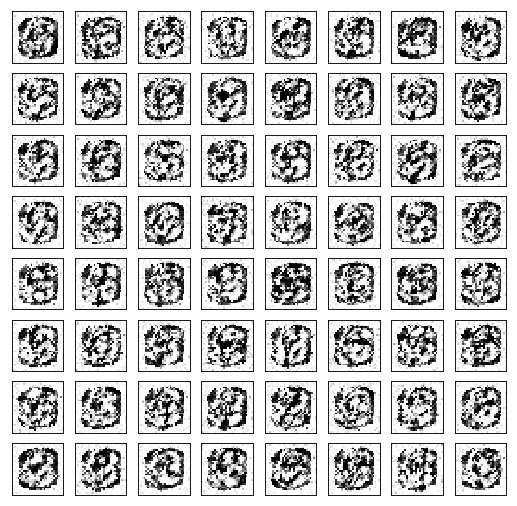

In [1121]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

### 2. Initialze inputs with real cifers

In [1122]:
train_loader, valid_loader, test_loader = mnist(batch_size=64, valid=10000, transform=mnist_transform)
inputs, _ = next(iter(test_loader))
inputs.shape

torch.Size([64, 1, 28, 28])

In [1123]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [1124]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.0263929 0.0378658
500	0.0077260 0.0029618
1000	0.0030244 0.0022172
1500	0.0018359 0.0010494
2000	0.0007924 0.0008674
2500	0.0006724 0.0005652
3000	0.0003792 0.0004299
3500	0.0003374 0.0003069
4000	0.0003120 0.0002274
4500	0.0002949 0.0001724
5000	0.0002827 0.0001340
5500	0.0002738 0.0001043
6000	0.0002672 0.0000825


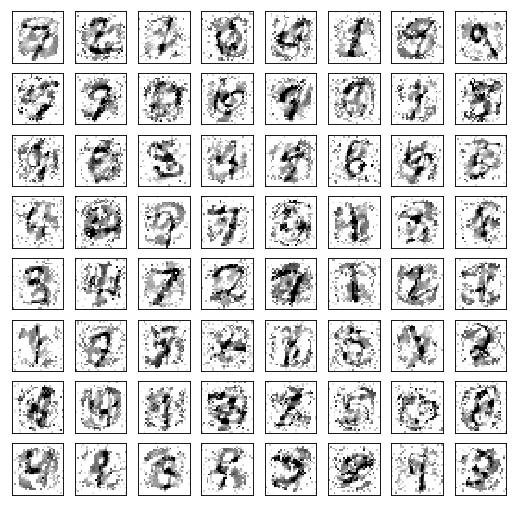

In [1125]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

### 3. Initialze inputs with ones

In [1126]:
inputs = torch.ones([64, 1, 28, 28])
print("Sum of elements: {}".format(inputs.sum().item()))
print("Tensor shape: {}".format(inputs.shape))

Sum of elements: 50176.0
Tensor shape: torch.Size([64, 1, 28, 28])


In [1127]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [1128]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.3736448 0.1289733
500	0.2713240 0.0569402
1000	0.2513463 0.0159985
1500	0.2437990 0.0044352
2000	0.2205462 0.0065189
2500	0.2048077 0.0077462
3000	0.1921926 0.0057890
3500	0.1872236 0.0038265
4000	0.1846547 0.0026950
4500	0.1829807 0.0020390
5000	0.1817644 0.0014827
5500	0.1806444 0.0012340
6000	0.1799740 0.0008858
6500	0.1795103 0.0006523
7000	0.1791382 0.0004631
7500	0.1790483 0.0003566
8000	0.1789961 0.0002479
8500	0.1789650 0.0001834
9000	0.1789440 0.0001425
9500	0.1789289 0.0001032
10000	0.1789187 0.0000791
10500	0.1789117 0.0000616
11000	0.1789068 0.0000462


KeyboardInterrupt: 

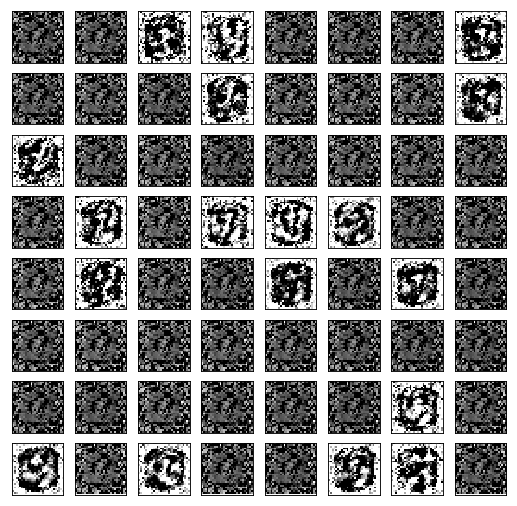

In [1129]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

**Выводы**
1. При инициализации батча картинок размером [64, 1, 28, 28] нулевыми значениями - мы находим входные изображения, соответствующие максимальным входным активациям каждого из 64 нейронов.
2. Однако в случае инициализации реальными картинками мы замечаем, что некоторые пиксели не изменяют своего значения или именяют на небольшое значение (остаются черными), то есть практически не вносят вклад в конечный one-hot вектор активаций на выходе кодировщика
3. Если инициализировать входной батч единичными значениями, алгоритм не сходится для некоторых one-hot векторов.